In [ ]:
# Question 4 and its extra credit problem was run on Kaggle to imrove training speed by using its GPU accelerator. 

In [1]:
import pandas as pd
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import VGG16

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
import keras.optimizers

from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk import word_tokenize
from skimage.color import gray2rgb
import keras
import numpy as np
import argparse
import cv2
import os

Using TensorFlow backend.


In [2]:
#These are from question 2

#Obtain training dataset and testing dataset
X_train = np.load('../input/input/np_training_data.npy')
df_train=pd.read_csv('../input/input/facial_expression.csv')
emotions=df_train.emotion
y_train = np.array(emotions)
df_test = pd.read_csv('../input/input/test.csv')
#Convert X_test to a numpy ndarray so that it can be used for testing
pixels = df_test.loc[:,'pixels'].values
px = []
for x in pixels : 
    x = word_tokenize(x)
    x = [float(t) for t in x]
    px.append(x)
X_test = np.array(px)
#Convert Y_test
y_test = df_test.loc[:, 'emotion'].values
#Modify x_train to 2d
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (26859, 2304)
y_train (26859,)
X_test (1044, 2304)
y_test (1044,)


In [3]:
X_train = X_train.reshape((26859, 48, 48))
X_test = X_test.reshape((1044, 48, 48))
print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (26859, 48, 48)
X_test (1044, 48, 48)


In [4]:
X_train_= gray2rgb(X_train)
X_test_ = gray2rgb(X_test)
print("X_train_", X_train_.shape)
print("X_test_", X_test_.shape)

X_train_ (26859, 48, 48, 3)
X_test_ (1044, 48, 48, 3)


In [5]:
X_train_ = X_train_.astype('float32')
X_test_ = X_test_.astype('float32')
X_train_ /= 255
X_test_ /= 255

In [6]:
print("X_train_", X_train_.shape)
print("y_train", y_train.shape)
print("X_test_", X_test_.shape)
print("y_test", y_test.shape)

X_train_ (26859, 48, 48, 3)
y_train (26859,)
X_test_ (1044, 48, 48, 3)
y_test (1044,)


In [7]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=30,
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest")
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [8]:
# load VGG16
vgg16 = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')
print(vgg16.summary())

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [9]:
y_train = keras.utils.to_categorical(y_train, 7)
y_test = keras.utils.to_categorical(y_test, 7)

In [10]:
model = Sequential()
# model.add(Dense(256, input_shape=(256,), activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(7, activation='softmax'))

# construct on top of the base model
model = vgg16.output
model = AveragePooling2D(pool_size=(1, 1))(model)
model = Flatten(name="flatten")(model)
model = Dense(256, input_shape=(256,), activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(7, activation="sigmoid")(model)

model = Model(inputs=vgg16.input, outputs=model)



model.compile(loss='categorical_crossentropy',
              optimizer='adadelta', metrics=['accuracy'])

model.fit(X_train_, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(X_test_, y_test))


Train on 26859 samples, validate on 1044 samples
Epoch 1/12
26859/26859 [==============================] - 20s 729us/step - loss: 1.7940 - accuracy: 0.2467 - val_loss: 1.7489 - val_accuracy: 0.2471
Epoch 2/12
26859/26859 [==============================] - 14s 524us/step - loss: 1.7228 - accuracy: 0.2645 - val_loss: 1.7600 - val_accuracy: 0.2270
Epoch 3/12
26859/26859 [==============================] - 14s 523us/step - loss: 1.4548 - accuracy: 0.3968 - val_loss: 1.2941 - val_accuracy: 0.4425
Epoch 4/12
26859/26859 [==============================] - 14s 524us/step - loss: 1.2811 - accuracy: 0.4781 - val_loss: 1.1747 - val_accuracy: 0.4828
Epoch 5/12
26859/26859 [==============================] - 14s 530us/step - loss: 1.1966 - accuracy: 0.5281 - val_loss: 1.3039 - val_accuracy: 0.4741
Epoch 6/12
26859/26859 [==============================] - 14s 525us/step - loss: 1.1091 - accuracy: 0.5685 - val_loss: 1.1974 - val_accuracy: 0.5536
Epoch 7/12
26859/26859 [==============================] -

In [11]:
loss, accuracy = model.evaluate(X_test_, y_test)

1044/1044 [==============================] - 0s 394us/step


In [12]:
print("accuracy:", accuracy)

accuracy: 0.7892720103263855


In [13]:
#Convert y_test to single digits for making the confusion matrix
rounded_y_test=np.argmax(y_test, axis=1)
rounded_y_test[10]

0

In [14]:
#Confusion Matrix
predictions_vgg = model.predict(X_test_)
np.argmax(predictions_vgg[10])
y_pred_vgg = [np.argmax(predictions_vgg[num]) for num in range(len(y_test))]
confusion_vgg = confusion_matrix(rounded_y_test,y_pred_vgg) 

(6.0, 0.0)

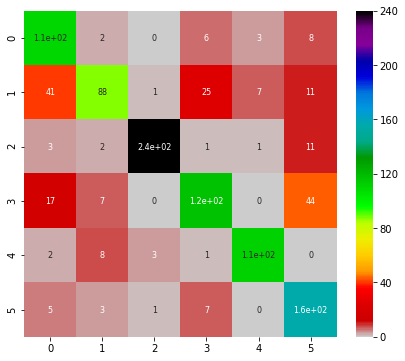

In [15]:
# Plot the confusion matrix
confusion_df_vgg = pd.DataFrame(confusion_vgg, range(6), range(6))
figure_vgg = plt.figure(figsize=(7,6))
axes_vgg = sns.heatmap(confusion_df_vgg, annot=True,annot_kws={"size": 8},
 cmap=plt.cm.nipy_spectral_r)
axes_vgg.set_ylim(sorted(axes_vgg.get_xlim(), reverse=True))

In [16]:
X_test_grey = X_test.reshape((1044, 48, 48, 1))

In [17]:
#Convert data format so that it can be plotted
images_vgg = X_test_grey.reshape((1044, 48, 48))
incorrect_predictions_vgg = []
#Find all the incorrect predictions by comparing with test data and predicted result
for i, (pred, expect) in enumerate(zip(predictions_vgg, rounded_y_test)):
    predicted, expected = np.argmax(pred), expect
    if predicted != expected:
        incorrect_predictions_vgg.append(
             (i, images_vgg[i], predicted, expected))

In [18]:
incorrect_predictions_vgg

[(7, array([[169., 179., 187., ..., 211., 210., 209.],
         [171., 173., 188., ..., 212., 211., 210.],
         [173., 173., 192., ..., 213., 212., 212.],
         ...,
         [164., 168., 168., ..., 197., 196., 203.],
         [159., 166., 171., ..., 196., 198., 206.],
         [156., 160., 167., ..., 196., 202., 205.]]), 4, 1),
 (11, array([[ 63.,  52.,  52., ...,  75.,  60.,  72.],
         [ 43.,  41.,  43., ...,  89.,  51.,  56.],
         [ 28.,  33.,  40., ...,  82.,  58.,  52.],
         ...,
         [134., 124., 122., ...,  37.,  37.,  39.],
         [133., 135., 126., ...,  34.,  44.,  43.],
         [127., 132., 121., ...,  40.,  45.,  38.]]), 4, 2),
 (17, array([[ 22.,  22.,  23., ...,  36.,  42.,  57.],
         [ 55.,  32.,  25., ...,  32.,  50.,  62.],
         [ 51.,  22.,  22., ...,  28.,  58.,  65.],
         ...,
         [198., 199., 205., ..., 238., 237., 235.],
         [194., 206., 206., ..., 238., 236., 235.],
         [196., 204., 212., ..., 238., 236., 

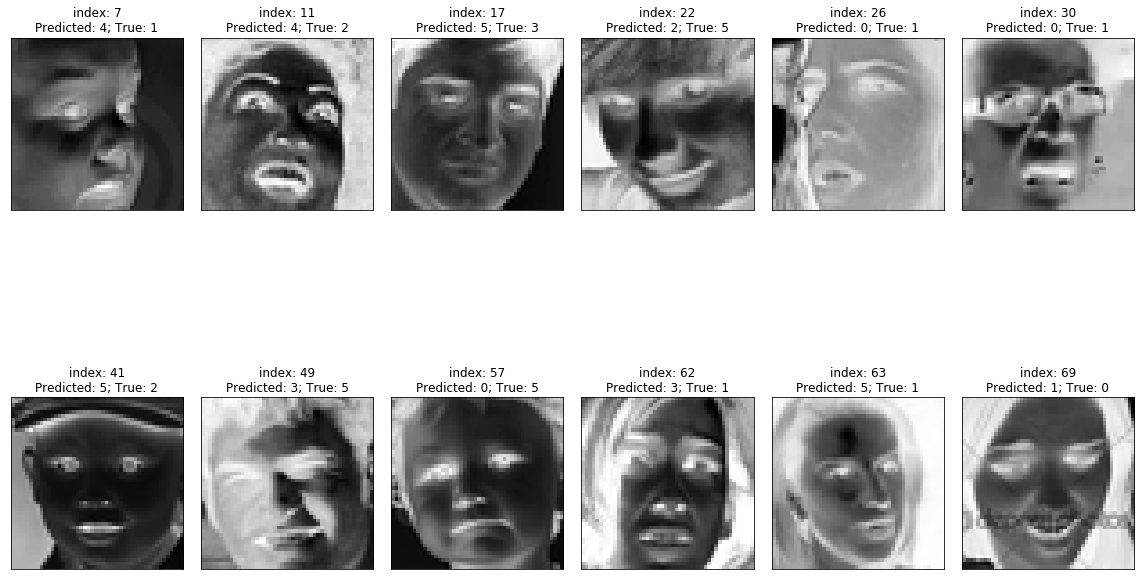

In [19]:
#Plot the first 12 incorrect predictions
figure, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 12))
for axes, item in zip(axes.ravel(), incorrect_predictions_vgg):
 index, image, predicted, expected = item
 axes.imshow(image, cmap=plt.cm.gray_r)
 axes.set_xticks([]) # remove x-axis tick marks
 axes.set_yticks([]) # remove y-axis tick marks
 axes.set_title(f'index: {index}\nPredicted: {predicted}; True: {expected}')
plt.tight_layout()

In [ ]:
#This completes Q4